## Module

In [4]:
import os
import os.path as pth
import cv2
import time
import shutil
import random
import collections
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Concatenate

from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

## Device

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [6]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.4.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12206809847372470792
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10480969344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15999864091453684659
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:64:00.0, compute capability: 7.5"
]


### Multi Device

In [ ]:
#tf.compat.v1.disable_eager_execution()
#mirrored_strategy = tf.distribute.MirroredStrategy()
#mirrored_strategy = tf.distribute.MirroredStrategy(devices = ["/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"])

In [7]:
PATH = '../molecular_data/'
TRAIN_DIR = PATH + 'train'
TEST_DIR = PATH + 'test'

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

class CFG : 
    debug = False
    size = 300
    data_ut = 2424186 #2424186 #500000
    seed = 42
    batch_size = 128
    buffer_size = 1000
    embedding_dim = 256
    units = 512
    top_k = 5000
    vocab_size = top_k + 1
    features_shape = 2048
    attention_features_shape = 64
    learning_rate = 5 * 1e-4
    
    model_encoder_name = 'CustomDenseNet-121'
    base_channel = 8
    model_base_path = pth.join('model', 'checkpoint')
    model_checkpoint = '001633.hdf5'

In [8]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Data Load

In [9]:
train_df = pd.read_csv(pth.join(PATH, 'train_labels.csv'))

In [10]:
def get_path(img_name) : 
    return f"{TRAIN_DIR}/{img_name[0]}/{img_name[1]}/{img_name[2]}/{img_name}.png"

train_df['path'] = train_df['image_id'].apply(get_path)

In [11]:
train_df

,image_id,InChI,path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,../molecular_data/train/0/0/0/000011a64c74.png
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,../molecular_data/train/0/0/0/000019cc0cd2.png
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,../molecular_data/train/0/0/0/0000252b6d2b.png
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,../molecular_data/train/0/0/0/000026b49b7e.png
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,../molecular_data/train/0/0/0/000026fc6c36.png
...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,../molecular_data/train/f/f/f/ffffe824f539.png
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,../molecular_data/train/f/f/f/ffffea1ebdfa.png
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,../molecular_data/train/f/f/f/ffffee2b4534.png
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,../molecular_data/train/f/f/f/fffff0b6eea6.png


In [12]:
all_captions = []
all_img_name_vector = []

for i in tqdm(range(len(train_df))) : 
    all_captions.append(train_df['InChI'].iloc[i])
    all_img_name_vector.append(train_df['path'].iloc[i])

  0%|          | 0/2424186 [00:00<?, ?it/s]

In [13]:
train_captions, train_img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = CFG.seed)
train_captions = train_captions[:CFG.data_ut]
train_img_name_vector = train_img_name_vector[:CFG.data_ut]

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3


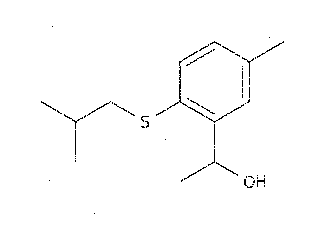

In [14]:
print(all_captions[0])
Image.open(all_img_name_vector[0])

## Tokenizer

In [15]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
    
#max_length = calc_max_length(all_captions)
#max_length = 100

In [16]:
top_k = CFG.top_k
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = "<unk>",
                                                  filters = '!"#$%&*+.-;?@[]^`{}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of InChI
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding = 'post')
max_length = calc_max_length(train_seqs)

In [17]:
tokenizer.sequences_to_texts(
    train_seqs
) # 찍어보기

['<unk> 10 19 14(27 <unk> 10)7 13(26 <unk> 5 16(29 <unk> 3)6 12(11)15 8 23 9 18(25 15)31 4/h5 6,8 <unk> <unk> /m1/s1',
 '<unk> 4 <unk> 7 21 8 12 <unk> 21)28 15 26(11 5 <unk> 18 22 6 9 23(16 <unk> 22)17 30/h5 6,8 9,11 <unk> <unk> 18h2,1 3h3',
 '<unk> 27 19 12 10 17(11 13 19)16 22 <unk> 18 7 5 6 14 <unk> 8 3 2 4 9 20/h2 4,8 <unk> 7,14 <unk> /m1/s1',
 '<unk> 13 6 7 <unk> <unk> 8 18)11 12 4 2 1 3 5 12/h1 <unk>',
 '<unk> 9 8 12(18 17 <unk> 14(6 7 14)10 2 4 11(15)5 3 10/h2 5,8h,6 <unk>',
 '<unk> 16(2)15 28 23(21 11 6 12 31 <unk> 9 3 4 10 <unk> 18 8 5 7 17(13 18)14 26/h3 <unk> <unk> 2h3,(h,27,29)',
 '<unk> <unk> 17 9 25(10 18 29)33 <unk> 11 19 30(20 12 <unk> <unk> 15 23 32(24 16 <unk> <unk> 13 21 31(22 14 <unk> 24h,1 8h3',
 '<unk> 9 5 7 10(8 6 9)19 13(20)11 3 1 2 4 12(11)17 14(19)18 16/h1 <unk>',
 '<unk> 2 3 4 5 6 7 <unk> <unk>',
 '<unk> 3 5 12 10 8 17 7 <unk> <unk> 4 2/h9 10,12h,3 8h2,1 2h3,(h,13,14)',
 '<unk> <unk> 4 3 5 10(6 9)17 12(15)7 11(14)16 2/h3 6h,7h2,1 2h3',
 '<unk> <unk> 11 10 14 

## Dataset

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(train_img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys) # 지우기 수정 // Epoch마다 셔플하도록 만드는게 좋음 // Suffling이 됐는지 체크

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [19]:
img_name_train[0]

'../molecular_data/train/2/f/7/2f7d44c34df2.png'

In [20]:
cap_train[0]

array([  1,  34,  17,  12,   9,  80,  13, 397,  14,   1,   1,   6,   3,
         2,   5,   8,   1,   1, 251, 403,  37,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [21]:
def map_func(img_name, cap) : 
    img = tf.io.read_file(img_name)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.dtypes.cast(img, tf.float32)
    img = img/255.0
    img = tf.image.resize(img, (CFG.size, CFG.size))
    img = img.numpy()
    return img, cap

In [22]:
t_img, t_cap = map_func(img_name_train[0], cap_train[0])
t_img.shape

(300, 300, 1)

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(CFG.buffer_size).batch(CFG.batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Encoder

In [24]:
class CNN_Encoder(tf.keras.Model) : 
    def __init__(self, embedding_dim) : 
        super(CNN_Encoder, self).__init__()
        auto_encoder = tf.keras.models.load_model(pth.join(CFG.model_base_path, CFG.model_checkpoint))
        feature_encoder = auto_encoder.get_layer(CFG.model_encoder_name)
        
        self.encoder = feature_encoder
        self.fc = Dense(embedding_dim, activation = 'relu')
        
    def call(self, x) : 
        x = self.encoder(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        return x

## BahdanauAttention

In [25]:
class BahdanauAttention(tf.keras.Model) : 
    def __init__(self, units) : 
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden) : 
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis = 1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        return context_vector, attention_weights

## RNN_Decoder

In [26]:
class RNN_Decoder(tf.keras.Model) : 
    def __init__(self, embedding_dim, units, vocab_size) : 
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                      return_sequences = True,
                                      return_state = True,
                                      recurrent_initializer = 'glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, features, hidden) : 
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    
    def reset_state(self, batch_size) : 
        return tf.zeros((batch_size, self.units))

## Train

### Dataset

In [27]:
encoder = CNN_Encoder(CFG.embedding_dim)
decoder = RNN_Decoder(CFG.embedding_dim, CFG.units, top_k + 1)

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred) : 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./model/train"
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

In [ ]:
loss_plot = []
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<unk>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            total_loss = (loss / int(target.shape[1]))
            trainable_variables = encoder.trainable_variables + decoder.trainable_variables
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            return loss, total_loss

In [ ]:
EPOCHS = 20
num_steps = len(img_name_train) // CFG.batch_size 

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 1000 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Rate {:.4f}%'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), 100 * CFG.batch_size * batch / len(img_name_train)))
            
    # Let us save the loss info to visualize
    loss_plot.append(total_loss / num_steps)
    if epoch % 1 == 0:
        ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/num_steps))
    print ('Time taken for 1 epoch {:.6f} sec\n'.format(time.time() - start))

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, CFG.attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    #img_tensor_val = encoder.encoder(temp_input) # 1, 10, 10, 256
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) # 1, 100, 256
    #features = encoder(img_tensor_val)
    features = encoder(temp_input)
    dec_input = tf.expand_dims([tokenizer.word_index['<unk>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.show()

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (CFG.size, CFG.size))
    img = img.numpy()
    return img, image_path

def map_func(img_name, cap) : 
    img = tf.io.read_file(img_name)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.dtypes.cast(img, tf.float32)
    img = img/255.0
    img = tf.image.resize(img, (CFG.size, CFG.size))
    img = img.numpy()
    return img, cap

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)